# LSTM

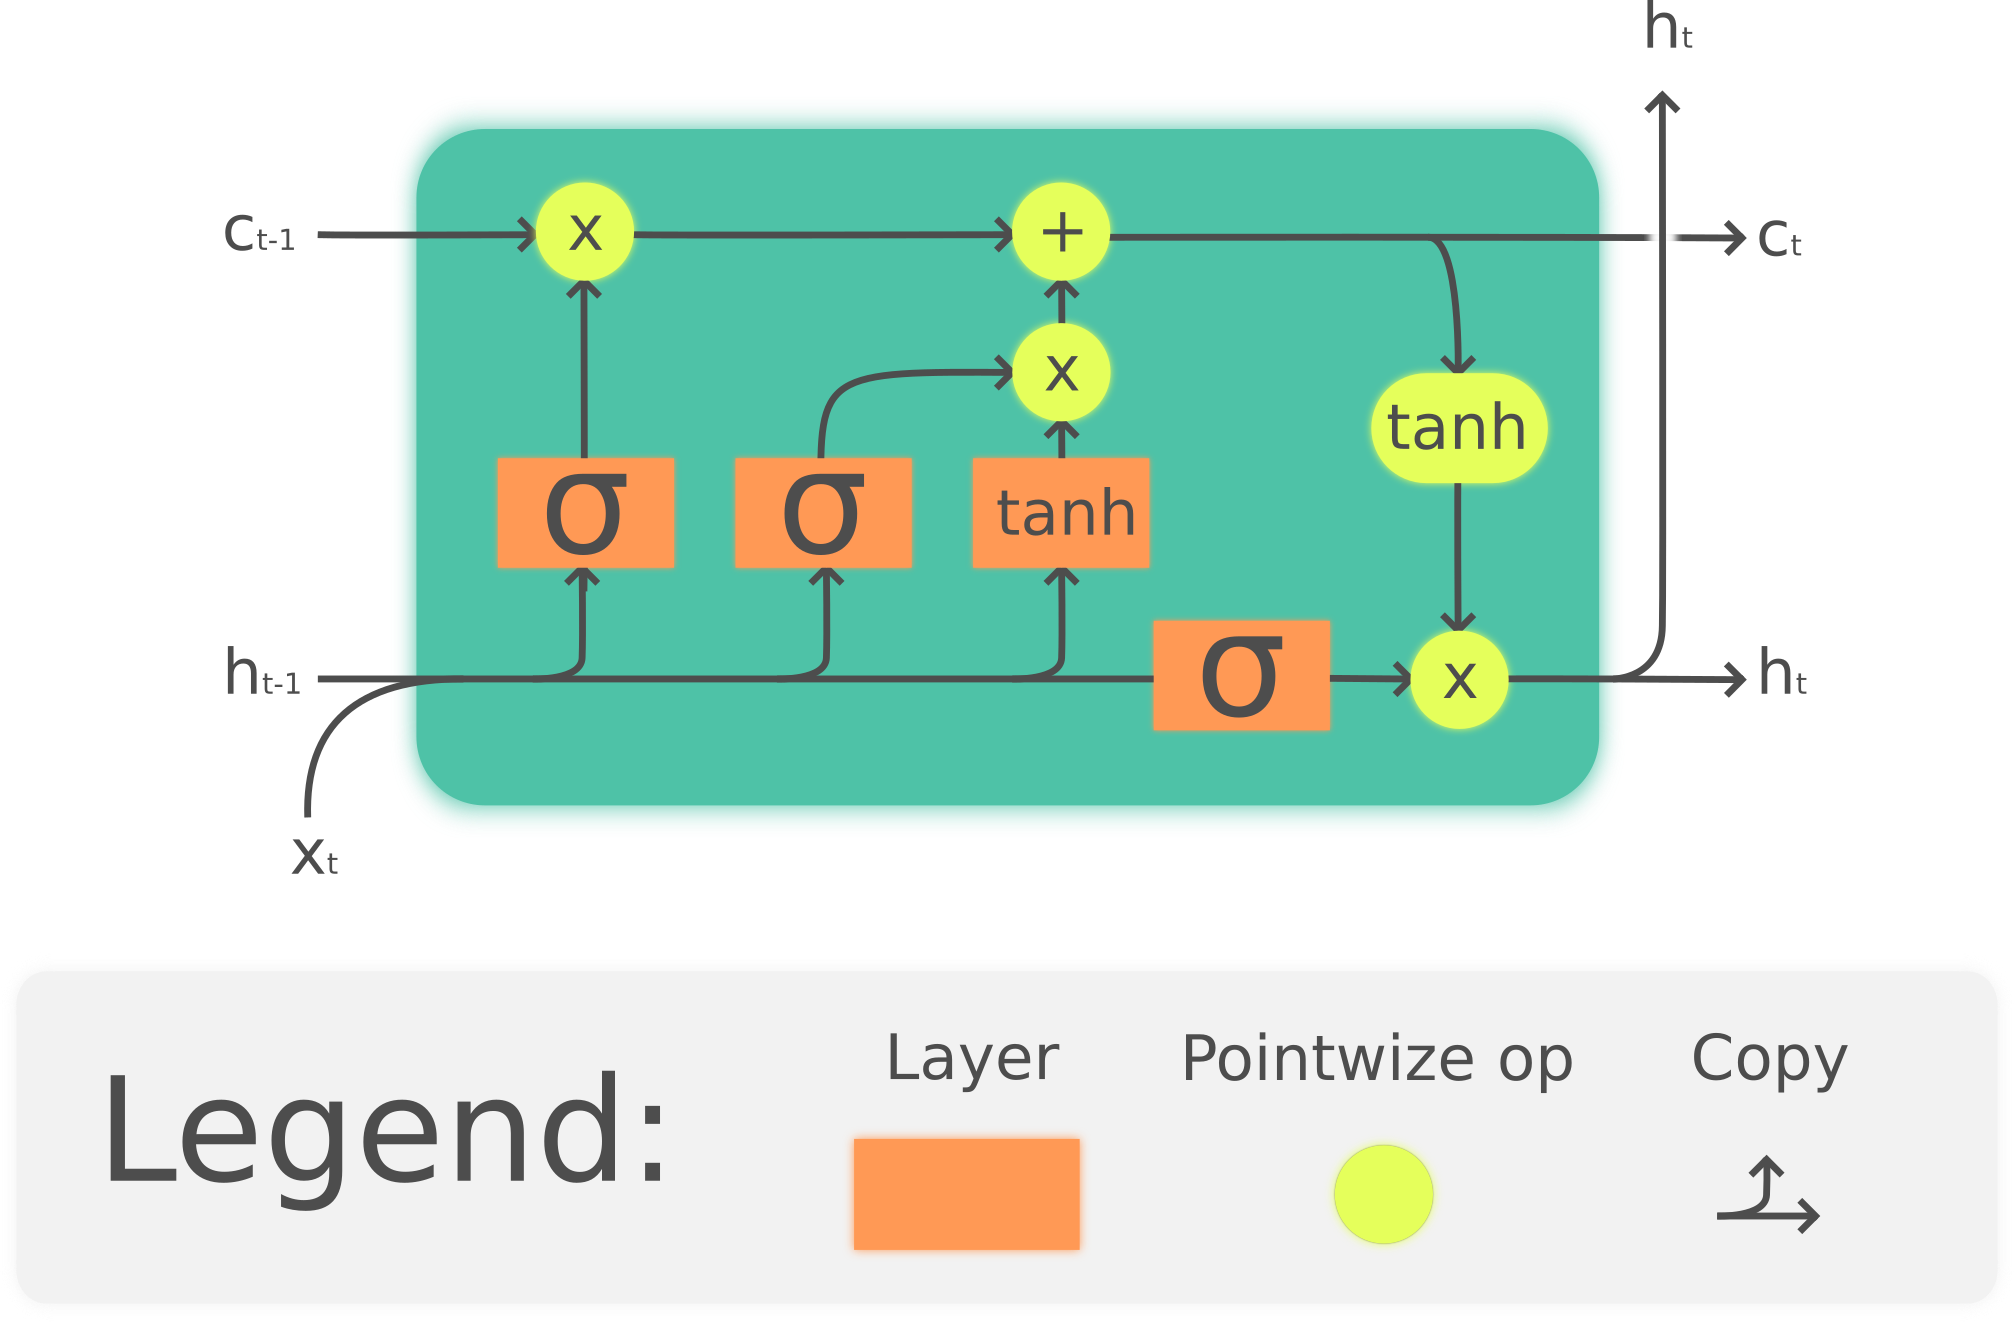
###  1. It stands for Long Short Term Memory
###  2. It is a type of recurrent neural network (RNN) designed to model long-term dependencies by addressing the vanishing gradient problem, enabling better sequence prediction and learning.

## In above figure we can see LSTM uses three gates:
### 1. Forget Gate: Decides which information from the previous cell state to forget. It outputs a number between 0 and 1 for each number in the cell state.

### 2. Input Gate: Determines which new information to store in the cell state. It has two parts:
#### 2.1. Input Gate Layer: Decides which values to update
#### 2.2. Candidate Layer: Creates a vector of new candidate values to be added to the state

### 3. Output Gate: Determines the output based on the cell state. It controls what parts of the cell state make it to the output.

## Cell State Update: Combines the previous cell state, the forget gate, and the input gate to update the current cell state.


# IMPORTING LIBRARIES

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder as OHE
import nltk
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy as CC
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import he_uniform, glorot_uniform
from tensorflow.keras.metrics import AUC
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
import tensorflow as tf

# READING DATA

In [2]:
ticket_data = pd.read_csv('data/ticket_data.csv')

# DATA OVERVIEW

In [3]:
ticket_data.head()

,Title,Body,Category,SubCategory,Opened At,Team
0,connection with icon,icon dear please setup icon per icon engineers...,Hardware,Memory,29/2/2016 01:16,Hardware Team
1,work experience user,work experience user hi work experience studen...,Hardware,Keyboard,29/2/2016 01:16,Hardware Team
2,requesting for meeting,requesting meeting hi please help follow equip...,Network,DNS,29/2/2016 04:40,Networking Team
3,reset passwords for external accounts,re expire days hi ask help update passwords co...,Network,VPN,29/2/2016 04:40,Networking Team
4,mail,verification warning hi has got attached pleas...,Network,VPN,29/2/2016 06:10,Networking Team


# TEXT DATA PREPROCESSING

In [4]:
def data_preprocess(data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('PorterStemmer')
    
    ## stop words list
    stop = stopwords.words("english")    
    stop_punc = list(set(punctuation))+stop
    
    ## Concatinating all text into one
    data['new'] = data['Title'] +" "+ data['Body']+ " "+data['Category']+" "+data['SubCategory']
    
    ## dropping off all un necessary columns
#     data = data.drop(['Title', 'Body', 'Category', 'SubCategory','Opened At'], axis = 1)
    
    ## lower casing the text
    data["lower_text"] = data['new'].map(lambda x:x.lower())
    
    def remove_stop(strings, stop_list):
        classed = [s for s in strings if s not in stop_list]
        return classed
    
    ## tokenizing the text
    data["tokenized"] = data['lower_text'].map(word_tokenize)
    
    ## removing stopwords based on stopword list
    data["selected"] = data['tokenized'].map(lambda df:remove_stop(df, stop_punc))
    
    def normalize(text):
        return " ".join(text)
    
    ## Stemmer object
    stemmer = PorterStemmer()

    ## stemming and normalizing the text
    data["stemmed"] = data['selected'].map(lambda xs:[stemmer.stem(x) for x in xs])
    data["normalized"] = data['stemmed'].apply(normalize)
    
    return data

def embeddings(data, tokenizer = None):
    ## Tokenizer object for text to vector conversion
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=1000)
        tokenizer.fit_on_texts(data['normalized'])
        tokenized_train = tokenizer.texts_to_sequences(data['normalized'])
    else:
    ## text to vector/sequence conversion
        tokenized_train = tokenizer.texts_to_sequences(data['normalized'])

    ## adding padding if required
    train_padded = pad_sequences(tokenized_train, maxlen=15, padding="pre")
    
    return tokenizer, train_padded


In [5]:
ticket_data = data_preprocess(ticket_data)
tokenizer, train_padded = embeddings(ticket_data)

[nltk_data] Downloading package punkt to C:\Users\MSI
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading PorterStemmer: Package 'PorterStemmer' not
[nltk_data]     found in index


## function to tranform the input, input will be having 0 or 1

In [6]:
def transform_x(data, tokenizer):
    output_shape = [data.shape[0],
                    data.shape[1],
                    tokenizer.word_index.keys().__len__()]
    results = np.zeros(output_shape)

    for i in range(data.shape[0]):
        for ii in range(data.shape[1]):
            results[i, ii, data[i, ii]-1] = 1
    return results

In [7]:
xtr_transformed = transform_x(train_padded, tokenizer)

## doing one hot encoding on output variable
y_encoder = OHE().fit(np.array(ticket_data.Team).reshape(-1, 1))
ytr_encoded = y_encoder.transform(np.array(ticket_data.Team).reshape(-1, 1)).toarray()

In [8]:
class LSTMModel(object):

    def build_model(self, input_dim, output_shape, steps, dropout_rate, kernel_regularizer, bias_regularizer):
        
        ## ADDING INPUT LAYER
        input_layer = Input(shape=(steps, input_dim))
        # ADDING LSTM LAYER
        lstm = LSTM(units=steps)(input_layer)
        
        # ADDING DENSE LAYER
        dense_1 = Dense(output_shape, kernel_initializer=he_uniform(),
                        bias_initializer="zeros",
                        kernel_regularizer=l2(l=kernel_regularizer),
                        bias_regularizer=l2(l=bias_regularizer))(lstm)
        
        # DOING NORMALIZATION
        x = BatchNormalization()(dense_1)
        x = relu(x)
        
        # ADDING DROPOUT LAYER TO AVOID OVERFITTING
        x = Dropout(rate=dropout_rate)(x)
        
        # ADDING DENSE LAYER(This is out put layer)
        o = Dense(output_shape, kernel_initializer=glorot_uniform(),
                  bias_initializer="zeros",
                  kernel_regularizer=l2(l=kernel_regularizer),
                  bias_regularizer=l2(l=bias_regularizer))(dense_1)
        o = BatchNormalization()(o)
        
        ## ADDING SOFTMAX ACTIVATION FUNCTION TO OUTPUT LAYER
        output = softmax(o, axis=1)
        
        # DEFINING LOSS
        loss = CC()
        
        # DEFINING METRIC
        metrics = AUC()
        
        # DEFINING OPTIMIZER
        optimizer = Adam()
        
        # ASSEMBLING INTO A MODEL
        self.model = Model(inputs=[input_layer], outputs=[output])
        
        # COMPILING A MODEL 
        self.model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

    def train(self, x, y, validation_split, epochs):
        ## MODEL TRAINING
        self.model.fit(x, y, batch_size=8, validation_split=validation_split, epochs=epochs)
        self.model.save(f"ticket_model.h5")

    def predict(self, x):
        return self.model.predict(x)

In [20]:
steps = xtr_transformed.shape[1]
dim = xtr_transformed.shape[2]
output_shape = ytr_encoded.shape[1]

model = LSTMModel()
model.build_model(input_dim=dim,
                  output_shape=output_shape,
                  steps=steps,
                  dropout_rate=0.5,
                  bias_regularizer=0.3,
                  kernel_regularizer=0.3)

In [21]:
model.train(xtr_transformed, ytr_encoded, 0.1, 30)

Epoch 1/30
781/781 [==============================] - 17s 17ms/step - loss: 1.6448 - auc_1: 0.9984 - val_loss: 0.3822 - val_auc_1: 1.0000
Epoch 2/30
781/781 [==============================] - 9s 12ms/step - loss: 0.3829 - auc_1: 1.0000 - val_loss: 0.1851 - val_auc_1: 1.0000
Epoch 3/30
781/781 [==============================] - 12s 16ms/step - loss: 0.2568 - auc_1: 1.0000 - val_loss: 0.1332 - val_auc_1: 1.0000
Epoch 4/30
781/781 [==============================] - 11s 15ms/step - loss: 0.1947 - auc_1: 1.0000 - val_loss: 0.1077 - val_auc_1: 1.0000
Epoch 5/30
781/781 [==============================] - 11s 14ms/step - loss: 0.1637 - auc_1: 1.0000 - val_loss: 0.0892 - val_auc_1: 1.0000
Epoch 6/30
781/781 [==============================] - 10s 13ms/step - loss: 0.1347 - auc_1: 1.0000 - val_loss: 0.0794 - val_auc_1: 1.0000
Epoch 7/30
781/781 [==============================] - 11s 14ms/step - loss: 0.1151 - auc_1: 1.0000 - val_loss: 0.0694 - val_auc_1: 1.0000
Epoch 8/30
781/781 [===============

In [10]:
model = tf.keras.models.load_model('ticket_model.h5')

# Model Evaluation

In [11]:
test_data = pd.read_csv('data/test.csv').head(100)
test_data = data_preprocess(test_data)
tokenizer, test_padded = embeddings(test_data, tokenizer)
test_transformed = transform_x(test_padded, tokenizer)

[nltk_data] Downloading package punkt to C:\Users\MSI
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading PorterStemmer: Package 'PorterStemmer' not
[nltk_data]     found in index


In [12]:
preds = []

for x in test_transformed:
#     print(.shape)
    preds.append(y_encoder.inverse_transform(model.predict(np.array([x])))[0][0])

In [13]:
from sklearn.metrics import classification_report
print(classification_report(test_data['Team'], preds))

                 precision    recall  f1-score   support

        DB Team       1.00      1.00      1.00        20
  Hardware Team       1.00      1.00      1.00        18
Networking Team       1.00      1.00      1.00        15
  Software Team       1.00      1.00      1.00        22
   Support Team       1.00      1.00      1.00        25

       accuracy                           1.00       100
      macro avg       1.00      1.00      1.00       100
   weighted avg       1.00      1.00      1.00       100



# Lets create inferencing for this model

In [19]:
requirement = ['Title', 'Body', 'Category', 'SubCategory']
requirement_input = {}

for require in requirement:
    requirement_input[require] = [input(f'Please provide {require} : ')]
    
required_df = pd.DataFrame(requirement_input)
required_df = data_preprocess(required_df)
tokenizer, df_padded = embeddings(required_df, tokenizer)
df_transformed = transform_x(df_padded, tokenizer)
print(f'Team: ', y_encoder.inverse_transform(model.predict(df_transformed))[0][0])


Please provide Title : re change of discipline for
Please provide Body : re change discipline hello please find attached transfer form details needs changed his please fill back thank administration officer pm re change discipline thank job title mentioned definitely qualifies role similarly other colleagues discipline working days notice period fine he has assigned he performing tasks aligned role thanks wednesday pm re change discipline hello thank information also change his job title work contract moment benefits tax exemptions pm discipline roles consultant position has possibility tax free please let change his role also adjust notice period working days confirmation by order changes thank administration officer pm change discipline hello please change discipline starting st october he move pm discipline his grade benefits remain same his role please let needed side moment probably change discipline after rearrange allocation within discipline also change let initiate change once

[nltk_data] Downloading package punkt to C:\Users\MSI
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading PorterStemmer: Package 'PorterStemmer' not
[nltk_data]     found in index


Team:  Software Team


In [22]:
test_data[requirement].tail().values

array([['nae wants to access planning',
        'wants planning accept decline requests', 'Inquiry / Help',
        'Email'],
       ['wants to access systems',
        'wants reports accept decline requests', 'Database',
        'MS SQL Server'],
       ['monitor',
        'monitor dear work where spend debugging while parallel execute application flow grateful monitor separate work across two screens also productivity effectiveness increase contribute more two same sized monitors notice difference currently screen second monitor too same size monitor properly looking forward hearing regards',
        'Inquiry / Help', 'Antivirus'],
       ['forward rule',
        'forward rule dear please disable forward rule mailbox mailbox please disable forward rule mailbox mailbox thank regards lead ext',
        'Network', 'IP Address'],
       ['snow request',
        'snow guys please log assign snow knows about add filed how expire filter called thanks profile',
        'Hardware', 'Memory']]